# use Titus code to make barplots from the branchwater output


In [172]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2025-workflow-core99/'

# parquet files from branchwater
BASE_OUTPUTS=BASE+'/outputs.branchwater'

In [173]:
# imports
import polars as pl
import numpy as np
import sklearn.tree
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [182]:
dirpath = BASE_OUTPUTS+'/*.parquet'

bw_df = pl.scan_parquet(dirpath).collect()
bw_df = bw_df.with_columns(pl.col("query_name").alias("species"),
                           pl.col("match_name").alias("acc"))
bw_df = bw_df.select(["species", "acc", "containment", "intersect_hashes"])

# mimic the Web site search threshold of 0.1
bw_df = bw_df.filter(pl.col("intersect_hashes") >= 10000)


In [183]:
# get metadata, only compare WGS
metadata_df = (
    pl.scan_parquet("/group/ctbrowngrp5/sra-metagenomes/20241128-metadata.parquet")
    .filter(pl.col("acc") != "NP")
    .filter(pl.col("assay_type") == "WGS")
    .select(["acc", "organism", "bioproject"]) 
    .collect()
)

In [184]:
bw_df = bw_df.join(metadata_df, on="acc", how="left")

In [185]:
# remove shitty entries with shitty metatada
# What is so difficult about adding an ORGANISM TO THIS???? WHO DOES THIS. "metagenome" is NOT INFORMATIVE 
def remove_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null"
    ]
    return df.filter(~pl.col("organism").is_in(bad_values))

# group by organism and count number of bacteria per SRA 
def pivot_count(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .group_by(["organism", "count"])
        .len()  # count occurrences
        .pivot(
            values="len",
            index="organism",
            columns="count"
        )
        .fill_null(0)  # optional: fill missing with 0
    )

category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  

def group_for_plot(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/other': '#2a9d8f',
    'pig-associated': '#e9c46a'
    }

# plot the numbers
def plot_cat(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        color=[colors[c] for c in df_abs.index]
    )
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', loc='upper right')
    plt.tight_layout()


# plot relative percentages
def plot_cat_percent(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
    ax = df_norm.T.plot(
        kind='bar',
        stacked=True,
        figsize=(6,6),
        color=[colors[c] for c in df_norm.index]
    )
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()


In [186]:
# remove unnanotated metags
df = remove_unnannotated(bw_df)
# count number of orgs in each mG
counts_df = (
    df
    .group_by(["acc", "organism"])
    .len()
    .rename({"len": "count"})
)

# pivot 
dfp = pivot_count(counts_df)

/tmp/ipykernel_1056465/1760080362.py:21: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


In [187]:
# save then load as pandas bc dont want to rewrite all functions
dfp.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")
dfp =pd.read_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")


In [188]:
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
df_ind, df_cm = group_for_plot(dfp)

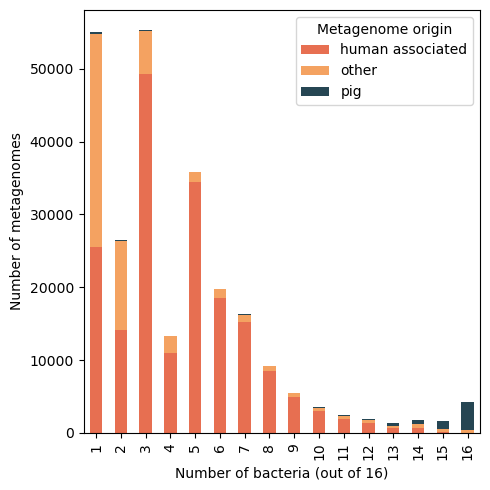

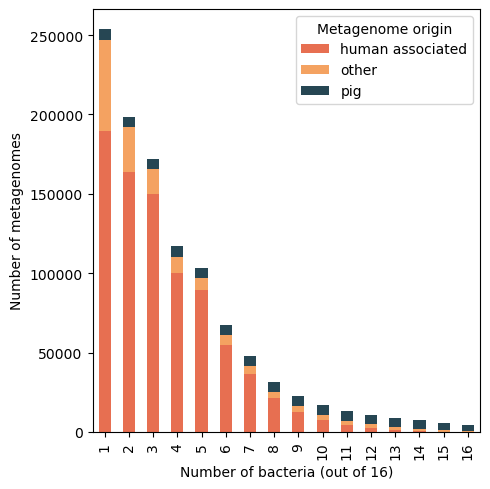

In [ ]:
# make chart with absolute numbers and not percentages
# 1kv threshold
plot_cat(df_ind)
plot_cat(df_cm)

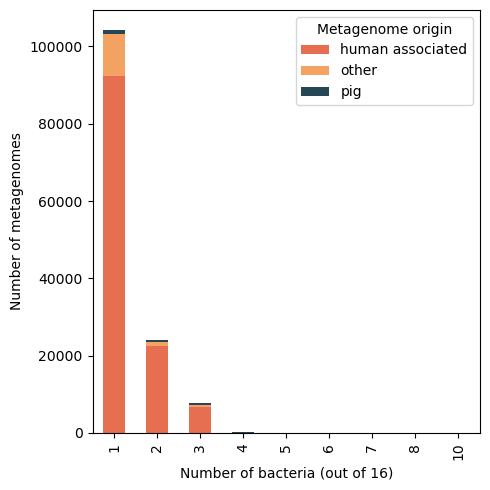

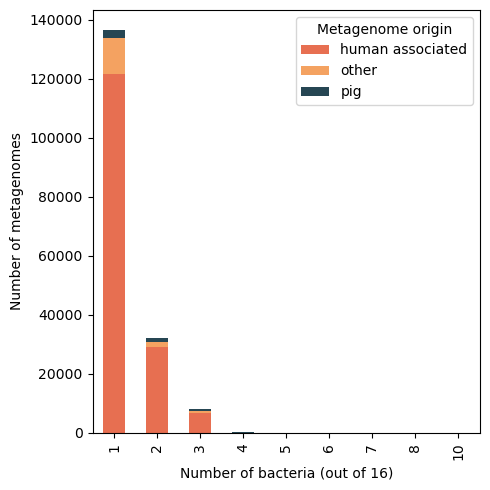

In [189]:
# 10kb threshold
plot_cat(df_ind)
plot_cat(df_cm)

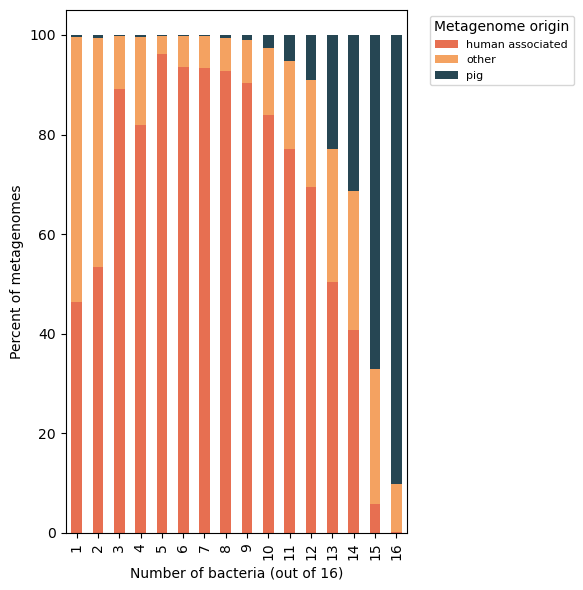

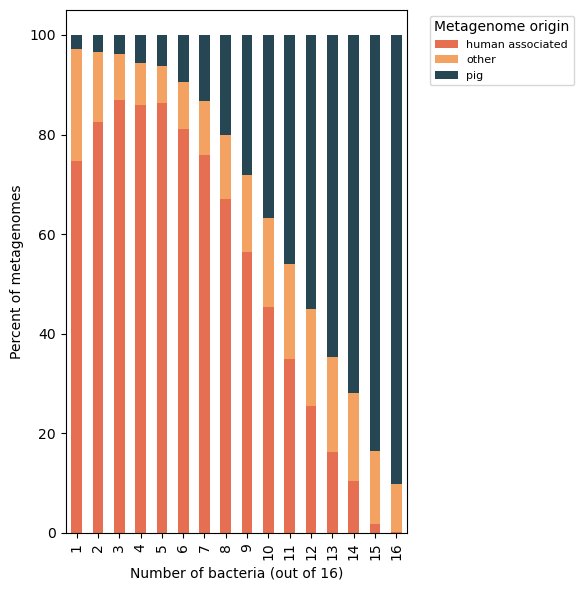

In [170]:
# Plot in percentages 
# this is skewed. at 16 spp there are only 33 entries
plot_cat_percent(df_ind)
plot_cat_percent(df_cm)

## Do some manual curation:
- We have 200.000 entries with a name such as "metagenome" (only will check if I have time)
- From annotated ones: Screen the "other" category

In [91]:
bw_df.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/bw_df.csv")
bw_df = pd.read_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/bw_df.csv")

In [ ]:
# man annotation
df_manual_annotation =pd.read_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/csv_files/251111_metag_mancur.csv') 


In [129]:
# merge mancur with original df
df2 = bw_df.merge(df_manual_annotation[['bioproject', 'manual_org']], on='bioproject',how='left')
df2['organism'] = df2['manual_org'].combine_first(df2['organism'])
df2 = df2.drop(columns=['manual_org'])


In [130]:
# get counts and whats missing fro mancur to add
df2['broad_cat'] = df2['organism'].apply(get_broad_cat_simple)
df2 = df2[['bioproject','organism','broad_cat']].value_counts().to_frame()
df2.to_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/acc_count_org.formancur2.csv")

In [127]:
df2

,,,count
bioproject,organism,broad_cat,
PRJEB51353,human gut metagenome,human associated,49048
PRJNA526405,pig,pig,36511
PRJEB38742,human gut metagenome,human associated,8223
PRJEB37249,human gut metagenome,human associated,8165
PRJEB11419,human gut metagenome,human associated,6166
...,...,...,...
PRJNA768556,bioreactor sludge metagenome,other,1
PRJNA979897,mine drainage metagenome,other,1
PRJDB1462,mouse gut metagenome,other,1


In [96]:
# change format for df
def pivot_count(df):
    df_pivot = pd.crosstab(df['organism'], df['count']).reset_index()
    df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]
    return df_pivot


In [98]:
counts_df2 = (
    df2.groupby(["acc", "organism"])
      .size()                   # counts the number of rows per group
      .reset_index(name="count")  # convert Series to DataFrame and name the count column
)


In [99]:
dfp = pivot_count(counts_df2)

In [101]:
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
df_ind, df_cm = group_for_plot(dfp)


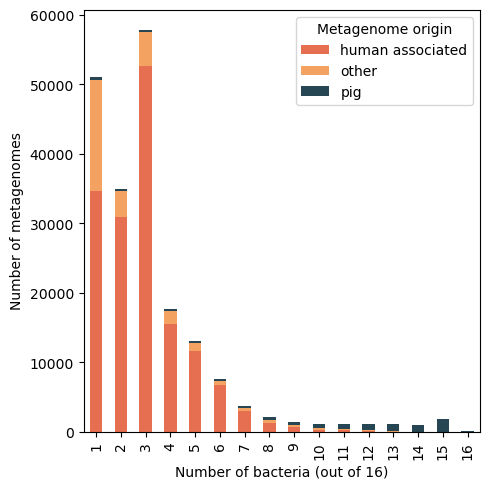

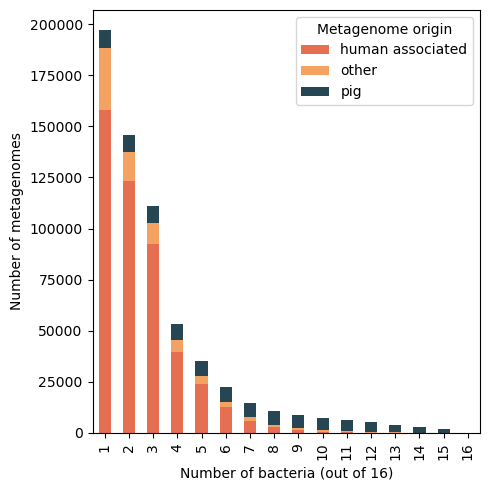

In [102]:
plot_cat(df_ind)
plot_cat(df_cm)

In [ ]:
# # also for these uninformative ones (at least check )
# def keep_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
#     bad_values = [
#         "metagenome",
#         "gut metagenome",
#         "feces metagenome",
#         "manure metagenome",
#         "bacterium",
#         "unidentified",
#         "null"
#     ]
#     return df.filter(pl.col("organism").is_in(bad_values))

# #keep
# df_unnanotated = keep_unnannotated(bw_df)
# df_unnanotated = (
#     df_unnanotated
#     .group_by(["organism", "bioproject"])
#     .len()
#     .rename({"len": "count"})
# )

# df_unnanotated.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/df_unnanotated.formancur.csv")